# Weight Initialization

This notebook show different weight initialize methods.

In [1]:
# Steup stuff
import matplotlib.pyplot as plt
import cv2
import numpy as np

## The problem with naive initialization of weights

The input to a neuron in the first layer of a neural network looks like: 

$$in = X_1 W_1 + X_2 W_2 + X_3 W_3 + X_4 W_4 ... = \sum_i^n X_i W_i$$


The variance of each element in this sum can be explained by the product of independent variables law:

$$var(X_i W_i) = [E(X_i)]^2\ var(W_i) + [E(W_i)]^2\ var(X_i) + var(X_i)\ var(W_i)$$

If we assume that the input has been appropriatly sclaed with a mean of 0 and a unit variance, and likewise we initialize the weights for a mean 0 and unit variance, then the result is:

$$var(X_i W_i) = 0 \cdot 1 + 0 \cdot 1 + 1 \cdot 1 = 1$$

So each product within the total sum of *in* has a variance of 1.

The total variance of the node input variable *in* is, under the assumption that each product is statistically independent an by applying the sum of uncorrelated independent variables law:

$$var(in) = \sum_{i=0}^n var(X_i W_i) = n \cdot 1 = n$$

Where *n* is the number of inputs. With an input of 784 the variance will be large and the standard deviation will be $\sqrt{(var(in))} = \sqrt{(784)} = 28$. This will result in the vast majority of neurons in the first layer being saturated, as most values will be $>> |2|$.

### Tanh and its derivative

/mnt/sdb1/Anaconda/envs/BScPRO/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


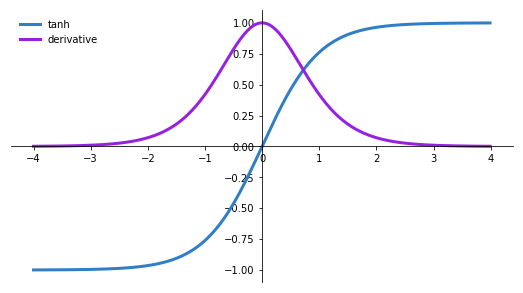

In [2]:
def tanh(z):
    ez = np.exp(z)
    enz = np.exp(-z)
    return (ez - enz)/ (ez + enz)

# Calculate plot points
z = np.arange(-4., 4., 0.01)
a = tanh(z)
dz = 1 - a**2

# Setup centered axes
fig, ax = plt.subplots(figsize=(9, 5))
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Create and show plot
ax.plot(z,a, color="#307EC7", linewidth=3, label="tanh")
ax.plot(z,dz, color="#9621E2", linewidth=3, label="derivative")
ax.legend(loc="upper left", frameon=False)
fig.show()

## Activations Statistics

Example given is a 10 layer network with 500 neurons on each layer, using tanh non-linearites.

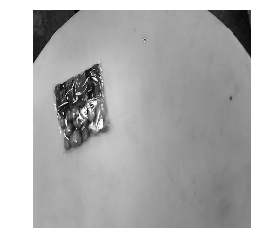

In [3]:
# assume some unit gaussian 10-D input data
# D = np.random.randn(1000, 500)
img = cv2.imread('input.png', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (224, 224))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()


D = cv2.normalize(img, None, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX)
hidden_layer_sizes = [224] * 10
nonlinearities = ['tanh'] * len(hidden_layer_sizes)
act = {'relu':lambda x:np.maximum(0, x), 'tanh':lambda x:np.tanh(x)}

### Small random numbers

Gaussian with zero mean and 0.01 standard deviation

**Layer initialization:** W = np.random.randn(fan_in, fan_out) * 0.01

In [4]:
Hs = []
for i, _ in enumerate(hidden_layer_sizes):
    X = D if i == 0 else Hs[i-1] # Input layer
    fan_in = X.shape[1]
    fan_out = hidden_layer_sizes[i]
    W = np.random.randn(fan_in, fan_out) * 0.01 # Layer initialization

    H = np.dot(X, W) # Matrix multiply
    H = act[nonlinearities[i]](H) # Nonlinearity
    Hs.append(H) # Cache results on this layer

Input layer had mean 0.876096 and std 0.329472
Hidden layer 1 had mean -0.014257 and std 0.138421
Hidden layer 2 had mean -0.000263 and std 0.020380
Hidden layer 3 had mean 0.000085 and std 0.003251
Hidden layer 4 had mean 0.000022 and std 0.000499
Hidden layer 5 had mean 0.000001 and std 0.000075
Hidden layer 6 had mean 0.000001 and std 0.000012
Hidden layer 7 had mean 0.000000 and std 0.000002
Hidden layer 8 had mean -0.000000 and std 0.000000
Hidden layer 9 had mean -0.000000 and std 0.000000
Hidden layer 10 had mean -0.000000 and std 0.000000


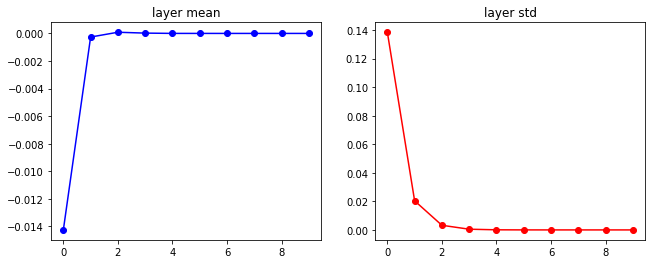

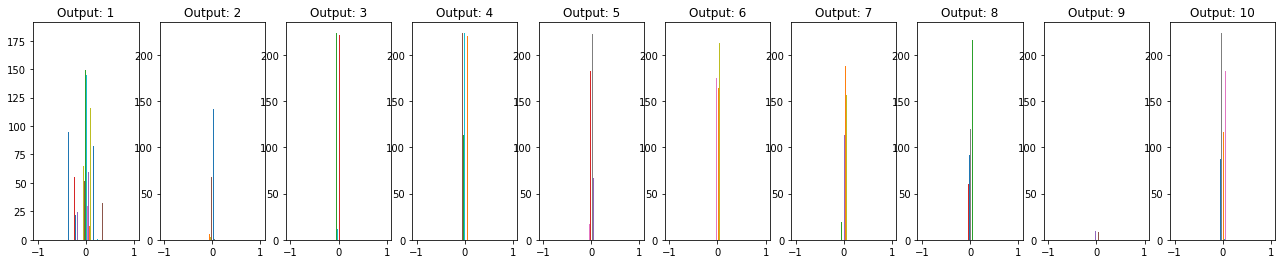

In [5]:
# Look at distributions at each layer
print('Input layer had mean %f and std %f' % (np.mean(D), np.std(D)))
layer_means = [np.mean(H) for H in Hs]
layer_stds = [np.std(H) for H in Hs]
for i, H in enumerate(Hs):
    print('Hidden layer %d had mean %f and std %f' % ((i+1), layer_means[i], layer_stds[i]))

# Plot the means and standard deviations
plt.figure()
plt.subplots_adjust(left=0.125, right=1.5)
plt.subplot(1, 2, 1)
plt.plot(range(len(Hs)), layer_means, 'ob-')
plt.title('layer mean')
plt.subplot(1, 2, 2)
plt.plot(range(len(Hs)), layer_stds, 'or-')
plt.title('layer std')

# Plot the raw distributions
plt.figure()
plt.subplots_adjust(left=0.125, right=3)
for (i, H) in enumerate(Hs):
    plt.subplot(1, len(Hs), (i+1))
    plt.title('Output: ' + str(i+1))
    plt.hist(H, 30, range=(-1.0, 1.0))

As we multiply by $W$, these small numbers at each layer, this quickly shrinks and collapses all of these values. At the end we only have zeros, which is not what we want.

All activations become zero! This becomes a problem for the backward pass, becuase X is small the weights are getting a very small gradient and basically not updating.

### Random values scaled by 1.0

**Layer initialization:** W = np.random.randn(fan_in, fan_out) * 1.0

In [6]:
Hs = []
for i, _ in enumerate(hidden_layer_sizes):
    X = D if i == 0 else Hs[i-1] # Input layer
    fan_in = X.shape[1]
    fan_out = hidden_layer_sizes[i]
    W = np.random.randn(fan_in, fan_out) * 1.0 # Layer initialization

    H = np.dot(X, W) # Matrix multiply
    H = act[nonlinearities[i]](H) # Nonlinearity
    Hs.append(H) # Cache results on this layer

Input layer had mean 0.876096 and std 0.329472
Hidden layer 1 had mean -0.034596 and std 0.973301
Hidden layer 2 had mean -0.003229 and std 0.971082
Hidden layer 3 had mean 0.015408 and std 0.969676
Hidden layer 4 had mean 0.040199 and std 0.970933
Hidden layer 5 had mean -0.000574 and std 0.972723
Hidden layer 6 had mean -0.008680 and std 0.971675
Hidden layer 7 had mean -0.009900 and std 0.972498
Hidden layer 8 had mean 0.003794 and std 0.971657
Hidden layer 9 had mean 0.008708 and std 0.973774
Hidden layer 10 had mean -0.007565 and std 0.972749


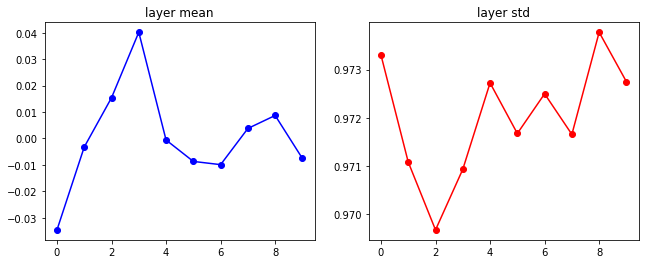

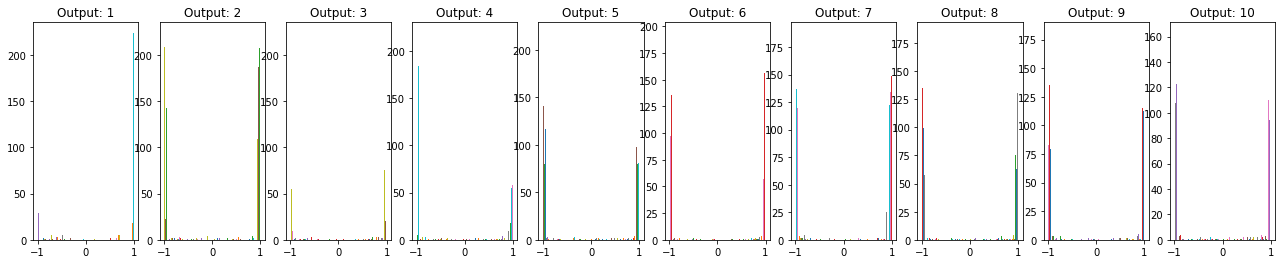

In [7]:
# Look at distributions at each layer
print('Input layer had mean %f and std %f' % (np.mean(D), np.std(D)))
layer_means = [np.mean(H) for H in Hs]
layer_stds = [np.std(H) for H in Hs]
for i, H in enumerate(Hs):
    print('Hidden layer %d had mean %f and std %f' % ((i+1), layer_means[i], layer_stds[i]))

# Plot the means and standard deviations
plt.figure()
plt.subplots_adjust(left=0.125, right=1.5)
plt.subplot(1, 2, 1)
plt.plot(range(len(Hs)), layer_means, 'ob-')
plt.title('layer mean')
plt.subplot(1, 2, 2)
plt.plot(range(len(Hs)), layer_stds, 'or-')
plt.title('layer std')

# Plot the raw distributions
plt.figure()
plt.subplots_adjust(left=0.125, right=3)
for (i, H) in enumerate(Hs):
    plt.subplot(1, len(Hs), i+1)
    plt.title('Output: ' + str(i+1))
    plt.hist(H, 30, range=(-1.0, 1.0))

Almost all neurons completely saturated, either -1 and 1. Gradients will be all zero. Because the weights are going to be big, tanh is always going to be at its saturated regimes of either very negative or very positive. When the tanh is saturated all the gradients will be zero and the weights will not be updating.

## Calibrating the variance with $\frac{1}{\sqrt{n}}$

One problem with the above suggestion is that the distrbution of the outputs from a randomly initialized neuron has a variance that grows with the number of inputs. The variance of each neurons output can be normalized to 1 by scaling its weight vector by a square root of its $fan_in$, i.e its number of inputs. Therefore, is each neurons weight vector initalized as: `W = np.random.randn(fan_in, fan_out) / np.sqrt(fan_in)`. This ensures that all neurons in the network initially have approximately the same outpuyt distribution and empirically improves the rate of convergence.

**The sketch of the derivation is as follows:**

Consider the inner product $s = \sum_i^n\ W_i\ X_i$ between the weights $W$ and input $X$, which gives the raw activation of a neuron before the non-linearity. The variance of $s$ is:

$$Var(s) = Var( \sum_i^n W_i\ X_i )$$
$$Var(s) = \sum_i^n\ Var(W_i\ X_i) $$
$$ Var(s) = \sum_i^n\ E[W_i]^2\ Var(X_i) + E[X_i]^2\ Var(W_i) + Var(X_i)\ Var(W_i) $$
$$ Var(s) = \sum_i^n\ Var(X_i)\ Var(W_i)$$
$$ Var(s) = (n \cdot Var(W))\ Var(X)$$

Where in the first 2 steps [properties of variance](https://en.wikipedia.org/wiki/Variance) is used. In third step zero mean and weights is assumed, so $E[X_i] = E[W_i] = 0$.

In [8]:
Hs = []
for i, _ in enumerate(hidden_layer_sizes):
    X = D if i == 0 else Hs[i-1] # Input layer
    fan_in = X.shape[1]
    fan_out = hidden_layer_sizes[i]
    W = np.random.randn(fan_in, fan_out) / np.sqrt(fan_in) # Layer initialization

    H = np.dot(X, W) # Matrix multiply
    H = act[nonlinearities[i]](H) # Nonlinearity
    Hs.append(H) # Cache results on this layer

Input layer had mean 0.876096 and std 0.329472
Hidden layer 1 had mean 0.046493 and std 0.595691
Hidden layer 2 had mean -0.028376 and std 0.482518
Hidden layer 3 had mean -0.017326 and std 0.399069
Hidden layer 4 had mean -0.021191 and std 0.324196
Hidden layer 5 had mean -0.017773 and std 0.302318
Hidden layer 6 had mean 0.010224 and std 0.278718
Hidden layer 7 had mean 0.011632 and std 0.247479
Hidden layer 8 had mean 0.000349 and std 0.239242
Hidden layer 9 had mean 0.008607 and std 0.224597
Hidden layer 10 had mean -0.011192 and std 0.209125


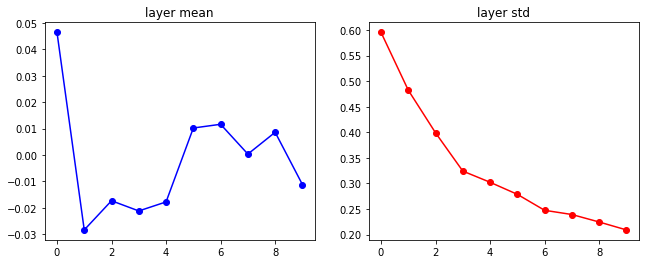

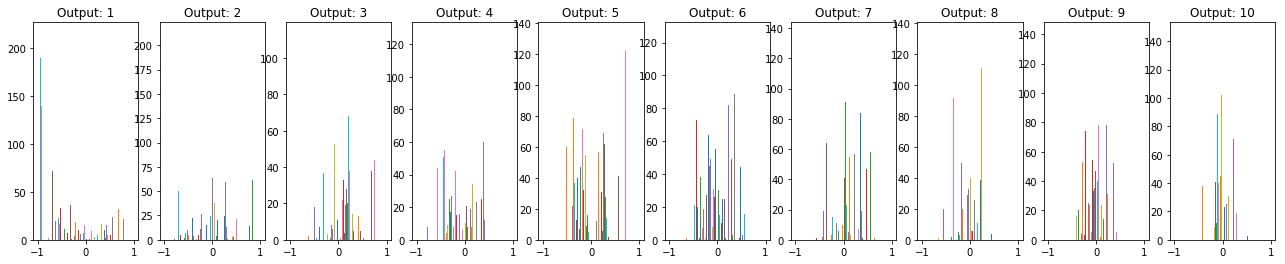

In [9]:
# Look at distributions at each layer
print('Input layer had mean %f and std %f' % (np.mean(D), np.std(D)))
layer_means = [np.mean(H) for H in Hs]
layer_stds = [np.std(H) for H in Hs]
for i, H in enumerate(Hs):
    print('Hidden layer %d had mean %f and std %f' % ((i+1), layer_means[i], layer_stds[i]))

# Plot the means and standard deviations
plt.figure()
plt.subplots_adjust(left=0.125, right=1.5)
plt.subplot(1, 2, 1)
plt.plot(range(len(Hs)), layer_means, 'ob-')
plt.title('layer mean')
plt.subplot(1, 2, 2)
plt.plot(range(len(Hs)), layer_stds, 'or-')
plt.title('layer std')

# Plot the raw distributions
plt.figure()
plt.subplots_adjust(left=0.125, right=3)
for (i, H) in enumerate(Hs):
    plt.subplot(1, len(Hs), i+1)
    plt.title('Output: ' + str(i+1))
    plt.hist(H, 30, range=(-1.0, 1.0))

This implementation sample from a standard gaussian and then scales byt the number of inputs. Thereby, specifing that the variance of the input shall be the same as the variance of the output.

Thus, if you have a small number of inputs, then we are going to divide by the smaller number and get larger weights. We need larger weights because with small inputs, and you are multiplying each of these by weight, you will need larger weights to get the same larger variance at output. If we have many inputs we want smaller weights in order to get the same variance at the output.

In the case above the goal is to have a unit gaussian as input to each layer, which approximately is acheived.

## Xavier or variance scaling for weight initialization

A similar analysis is carried out in [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) by Glorot et al. In this paper, the authors end up recommending an initialization of the form $Var(W) = \frac{2}{fan_{in} + fan_{out}}$. This is based on a compromise and an equivalent analysis of the backpropagated gradients.

### Xavier Uniform

Each neurons weight vector is initalized from a unifrom distribution within the $[-limit, limit]$, where $limit$ is $\sqrt{\frac{6}{(fan_{in} + fan_{out})}}$. Thus the layer initalization becomes `W = np.random.randn(fan_in, fan_out) * np.sqrt(6 / (fan_in + fan_out))`.

In [10]:
Hs = []

for i, _ in enumerate(hidden_layer_sizes):
    X = D if i == 0 else Hs[i-1] # Input layer
    fan_in = X.shape[1]
    fan_out = hidden_layer_sizes[i]
    limit = np.sqrt(6 / (fan_in + fan_out))
    W = np.random.randn(fan_in, fan_out) * limit # Layer initialization

    H = np.dot(X, W) # Matrix multiply
    H = act[nonlinearities[i]](H) # Nonlinearity
    Hs.append(H) # Cache results on this layer

Input layer had mean 0.876096 and std 0.329472
Hidden layer 1 had mean -0.100446 and std 0.743114
Hidden layer 2 had mean -0.037172 and std 0.702607
Hidden layer 3 had mean 0.041516 and std 0.653344
Hidden layer 4 had mean -0.023280 and std 0.666284
Hidden layer 5 had mean -0.025566 and std 0.664317
Hidden layer 6 had mean -0.033571 and std 0.669054
Hidden layer 7 had mean 0.008742 and std 0.669533
Hidden layer 8 had mean -0.018946 and std 0.662688
Hidden layer 9 had mean 0.015728 and std 0.662663
Hidden layer 10 had mean 0.036597 and std 0.677703


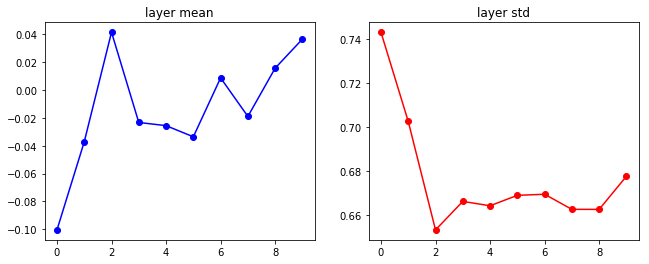

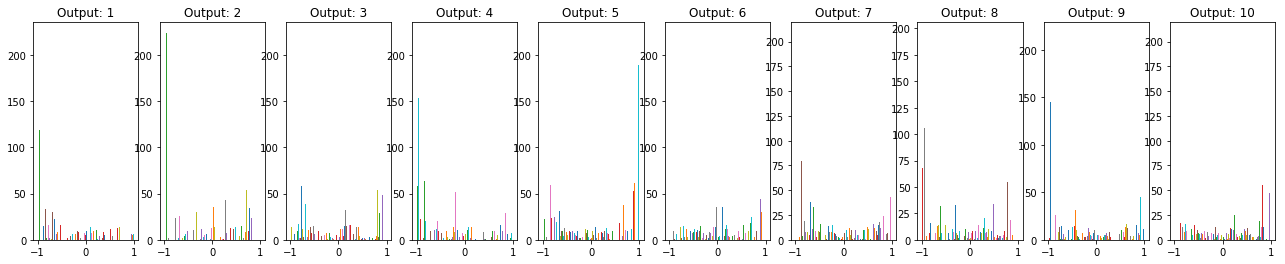

In [11]:
# Look at distributions at each layer
print('Input layer had mean %f and std %f' % (np.mean(D), np.std(D)))
layer_means = [np.mean(H) for H in Hs]
layer_stds = [np.std(H) for H in Hs]
for i, H in enumerate(Hs):
    print('Hidden layer %d had mean %f and std %f' % ((i+1), layer_means[i], layer_stds[i]))

# Plot the means and standard deviations
plt.figure()
plt.subplots_adjust(left=0.125, right=1.5)
plt.subplot(1, 2, 1)
plt.plot(range(len(Hs)), layer_means, 'ob-')
plt.title('layer mean')
plt.subplot(1, 2, 2)
plt.plot(range(len(Hs)), layer_stds, 'or-')
plt.title('layer std')

# Plot the raw distributions
plt.figure()
plt.subplots_adjust(left=0.125, right=3)
for (i, H) in enumerate(Hs):
    plt.subplot(1, len(Hs), i+1)
    plt.title('Output: ' + str(i+1))
    plt.hist(H, 30, range=(-1.0, 1.0))

## Using Activations Function ReLU

The above examples assumed that there is linear activations, that we are in the active region of the tanh, for example. This however becomes a problem. 

In [12]:
nonlinearities = ['relu'] * len(hidden_layer_sizes)
Hs = []
for i, _ in enumerate(hidden_layer_sizes):
    X = D if i == 0 else Hs[i-1] # Input layer
    fan_in = X.shape[1]
    fan_out = hidden_layer_sizes[i]
    W = np.random.randn(fan_in, fan_out) / np.sqrt(fan_in) # Layer initialization

    H = np.dot(X, W) # Matrix multiply
    H = act[nonlinearities[i]](H) # Nonlinearity
    Hs.append(H) # Cache results on this layer

Input layer had mean 0.876096 and std 0.329472
Hidden layer 1 had mean 0.376078 and std 0.547039
Hidden layer 2 had mean 0.256145 and std 0.396286
Hidden layer 3 had mean 0.194229 and std 0.284460
Hidden layer 4 had mean 0.135545 and std 0.203256
Hidden layer 5 had mean 0.098702 and std 0.141885
Hidden layer 6 had mean 0.077955 and std 0.110001
Hidden layer 7 had mean 0.041244 and std 0.066306
Hidden layer 8 had mean 0.029440 and std 0.046100
Hidden layer 9 had mean 0.021942 and std 0.032034
Hidden layer 10 had mean 0.017603 and std 0.021941


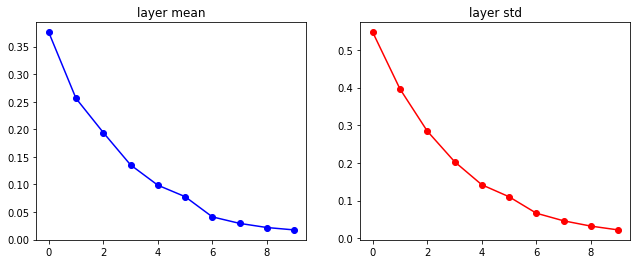

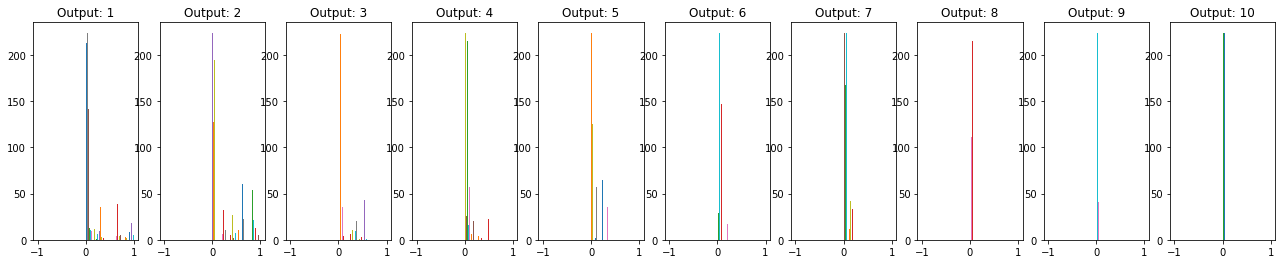

In [13]:
# Look at distributions at each layer
print('Input layer had mean %f and std %f' % (np.mean(D), np.std(D)))
layer_means = [np.mean(H) for H in Hs]
layer_stds = [np.std(H) for H in Hs]
for i, H in enumerate(Hs):
    print('Hidden layer %d had mean %f and std %f' % ((i+1), layer_means[i], layer_stds[i]))

# Plot the means and standard deviations
plt.figure()
plt.subplots_adjust(left=0.125, right=1.5)
plt.subplot(1, 2, 1)
plt.plot(range(len(Hs)), layer_means, 'ob-')
plt.title('layer mean')
plt.subplot(1, 2, 2)
plt.plot(range(len(Hs)), layer_stds, 'or-')
plt.title('layer std')

# Plot the raw distributions
plt.figure()
plt.subplots_adjust(left=0.125, right=3)
for (i, H) in enumerate(Hs):
    plt.subplot(1, len(Hs), i+1)
    plt.title('Output: ' + str(i+1))
    plt.hist(H, 30, range=(-1.0, 1.0))

But when using ReLU nonlinearity it breaks. More and more peaks toward zero and more units deactivated, because ReLU kills half of them. Thus, ReLU is halving the variance that you get out of this.

By making the same assumption as earlier you will not get the right variance coming out, as shown above, it is going to be too small. We see the phenomenon, as the distributions starts collapsing, that we get more and more peaks toward zero and more units deactivated.

### Xavier uniform with ReLU

In [14]:
nonlinearities = ['relu'] * len(hidden_layer_sizes)
Hs = []

for i, _ in enumerate(hidden_layer_sizes):
    X = D if i == 0 else Hs[i-1] # Input layer
    fan_in = X.shape[1]
    fan_out = hidden_layer_sizes[i]
    limit = np.sqrt(6 / (fan_in + fan_out))
    W = np.random.randn(fan_in, fan_out) * limit # Layer initialization

    H = np.dot(X, W) # Matrix multiply
    H = act[nonlinearities[i]](H) # Nonlinearity
    Hs.append(H) # Cache results on this layer

Input layer had mean 0.876096 and std 0.329472
Hidden layer 1 had mean 0.580541 and std 0.888008
Hidden layer 2 had mean 0.771764 and std 1.106968
Hidden layer 3 had mean 0.908487 and std 1.347962
Hidden layer 4 had mean 1.202222 and std 1.637769
Hidden layer 5 had mean 1.250977 and std 1.838552
Hidden layer 6 had mean 1.540130 and std 2.290200
Hidden layer 7 had mean 1.540100 and std 2.396776
Hidden layer 8 had mean 2.260363 and std 3.083091
Hidden layer 9 had mean 2.516035 and std 3.793323
Hidden layer 10 had mean 2.958139 and std 4.508936


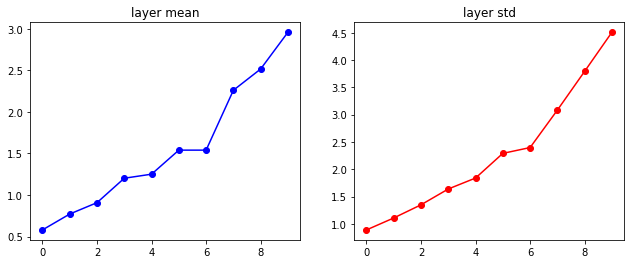

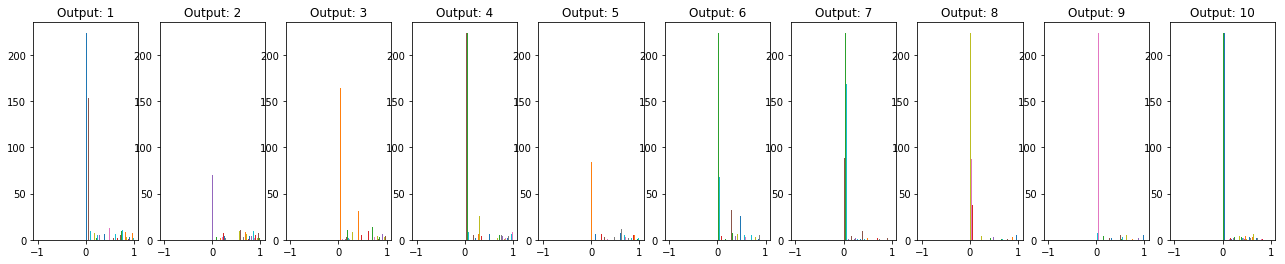

In [15]:
# Look at distributions at each layer
print('Input layer had mean %f and std %f' % (np.mean(D), np.std(D)))
layer_means = [np.mean(H) for H in Hs]
layer_stds = [np.std(H) for H in Hs]
for i, H in enumerate(Hs):
    print('Hidden layer %d had mean %f and std %f' % ((i+1), layer_means[i], layer_stds[i]))

# Plot the means and standard deviations
plt.figure()
plt.subplots_adjust(left=0.125, right=1.5)
plt.subplot(1, 2, 1)
plt.plot(range(len(Hs)), layer_means, 'ob-')
plt.title('layer mean')
plt.subplot(1, 2, 2)
plt.plot(range(len(Hs)), layer_stds, 'or-')
plt.title('layer std')

# Plot the raw distributions
plt.figure()
plt.subplots_adjust(left=0.125, right=3)
for (i, H) in enumerate(Hs):
    plt.subplot(1, len(Hs), i+1)
    plt.title('Output: ' + str(i+1))
    plt.hist(H, 30, range=(-1.0, 1.0))

## Initialization specifically for ReLU neurons

A recent paper, [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) by He et al, derives an initialization specifically for ReLU neurons, reaching the conclusion that the variance of neurons in the network should be $\frac{2.0}{n}$. This gives the initialization `W = np.random.randn(fan_in, fan_out) / np.sqrt(fan_in / 2.0)`, and is the current recommendation for use in practice in the specific case of neural networks with ReLU neurons.

In [16]:
Hs = []
for i, _ in enumerate(hidden_layer_sizes):
    X = D if i == 0 else Hs[i-1] # Input layer
    fan_in = X.shape[1]
    fan_out = hidden_layer_sizes[i]
    W = np.random.randn(fan_in, fan_out) / np.sqrt(fan_in / 2.0) # Layer initialization

    H = np.dot(X, W) # Matrix multiply
    H = act[nonlinearities[i]](H) # Nonlinearity
    Hs.append(H) # Cache results on this layer

Input layer had mean 0.876096 and std 0.329472
Hidden layer 1 had mean 0.477363 and std 0.759850
Hidden layer 2 had mean 0.484097 and std 0.708709
Hidden layer 3 had mean 0.442717 and std 0.758991
Hidden layer 4 had mean 0.555980 and std 0.788269
Hidden layer 5 had mean 0.551203 and std 0.737571
Hidden layer 6 had mean 0.500208 and std 0.799342
Hidden layer 7 had mean 0.538814 and std 0.818604
Hidden layer 8 had mean 0.433909 and std 0.692125
Hidden layer 9 had mean 0.396346 and std 0.599958
Hidden layer 10 had mean 0.436201 and std 0.612881


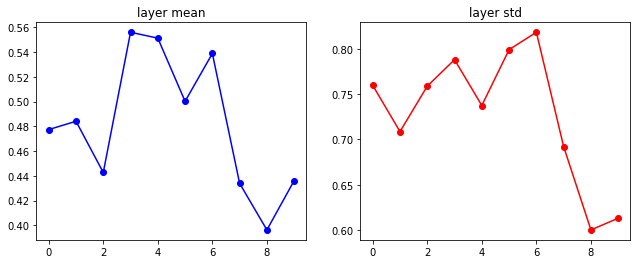

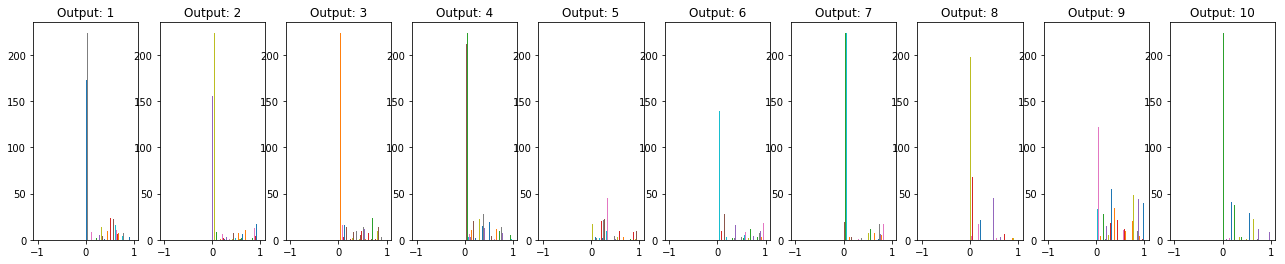

In [17]:
# Look at distributions at each layer
print('Input layer had mean %f and std %f' % (np.mean(D), np.std(D)))
layer_means = [np.mean(H) for H in Hs]
layer_stds = [np.std(H) for H in Hs]
for i, H in enumerate(Hs):
    print('Hidden layer %d had mean %f and std %f' % ((i+1), layer_means[i], layer_stds[i]))

# Plot the means and standard deviations
plt.figure()
plt.subplots_adjust(left=0.125, right=1.5)
plt.subplot(1, 2, 1)
plt.plot(range(len(Hs)), layer_means, 'ob-')
plt.title('layer mean')
plt.subplot(1, 2, 2)
plt.plot(range(len(Hs)), layer_stds, 'or-')
plt.title('layer std')

# Plot the raw distributions
plt.figure()
plt.subplots_adjust(left=0.125, right=3)
for (i, H) in enumerate(Hs):
    plt.subplot(1, len(Hs), i+1)
    plt.title('Output: ' + str(i+1))
    plt.hist(H, 30, range=(-1.0, 1.0))

## Sparse Initialization

Another way to address the uncalibrated variances problem is to set all weight matrices to zero, but to break symmetry every neuron is randomly connected, with weights sampled from a small gaussian as above, to a fixed number of neurons below it. 

## Initializing the biases

It is possible and common to initalize the biases to be zero, since the asymmetry breaking is provided by the small random number in the weights. For ReLU nonlinearities, some peoplelike to use small constant value such as $0.01$ for all biases because this ensures that all ReLU units fire in the begining and therefore obtain and propagate some gradient. However, it is not clear if this provides a consisten improvement, in fact some results seem to indicate that this performs worse, and it is more common to simply use $0$ bias initialization.